## Import

In [53]:
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind


from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
sc = StandardScaler()

## Caricamento dati

In [54]:

file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/data_rad_clin_DEF.csv"
#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\data_rad_clin_DEF.csv"
data = pd.read_csv(file_path)

# Lista degli ID da escludere
ids_to_exclude = ["patient_TC_19", "patient_TC_40", "patient_TC_88", "patient_TC_150", "patient_TC_193", "patient_TC_200", "patient_TC_17", "patient_TC_107", "patient_TC_127" ]


# Filtra il DataFrame per escludere le righe con gli ID specificati
filtered_data = data[~data['IDs_new'].isin(ids_to_exclude)]

# Estrae i valori dalla colonna 'label' del DataFrame filtrato
labels_column = filtered_data['label']

# Converte i valori della colonna 'label' in numeri interi
labels = labels_column.astype(int).tolist()

labels=np.array(labels)
print("Labels:", labels)
print("Number of labels:", len(labels))


# Carica il file CSV
file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/features_radiomiche.csv"  # Sostituisci con il percorso corretto
df = pd.read_csv(file_path, sep=';')

# Colonne da rimuovere
columns_to_remove = [
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

# Rimuovi le colonne specificate
df_cleaned = df.drop(columns=columns_to_remove)


# Rimuovi la colonna 'Paziente' per ottenere solo le feature
df_features = df_cleaned.drop(columns=['Paziente'])

# Converti le features in un array numpy
features = df_features.to_numpy()

# Stampa i risultati
print(features)
print(features.shape)  # (120, num_features)


Labels: [0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1
 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0
 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 1 0 1 1]
Number of labels: 120
[[6.42638351e-01 4.34811323e-01 1.16096656e+01 ... 2.69972505e+03
  2.80963106e-02 1.00514866e+01]
 [6.29082835e-01 5.34401455e-01 1.06699125e+01 ... 5.06730171e+03
  4.13964322e-02 9.21642811e+00]
 [5.33839928e-01 4.15372150e-01 1.11671922e+01 ... 3.95715175e+03
  1.13273940e-02 2.75076797e+01]
 ...
 [3.60780175e-01 3.10120345e-01 1.09248810e+01 ... 2.38010395e+03
  3.21141803e-02 3.22969245e+00]
 [4.66390756e-01 3.69394607e-01 1.32282545e+01 ... 1.36263582e+02
  6.99679621e-02 4.97074683e-01]
 [4.85039433e-01 3.32916705e-01 9.71060636e+00 ... 4.02397749e+03
  7.17804108e-02 4.97083572e+00]]
(120, 107)


## funzioni

In [55]:

def compute_correlation(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    return to_drop


def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop


def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    # Fit Lasso regression model
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)

    # Get coefficients
    coefficients = lasso.coef_

    # Select features with non-zero coefficients
    selected_features = np.where(coefficients != 0)[0]

    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]
    return X_selected, selected_features


def mrmr_feature_selection(X, y, num_features):
    # Calcolare l'informazione mutua tra ogni caratteristica e il target
    mi = mutual_info_classif(X, y)
    
    # Standardizzare le caratteristiche
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calcolare la distanza euclidea tra le caratteristiche
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []
    
    # Selezionare la prima caratteristica con la massima informazione mutua
    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    # Iterare per selezionare le caratteristiche rimanenti
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices



## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    # Inizializza il classificatore Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # Addestra il modello
    rf.fit(X, y)
    # Ottieni l'importanza delle caratteristiche
    feature_importances = rf.feature_importances_
    # Seleziona gli indici delle caratteristiche più importanti
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    # Crea una nuova matrice di caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_features]
    return X_selected, selected_features


def p_value_feature_selection(X, num_features):
    """
    Seleziona le prime `num_features` caratteristiche dal vettore di caratteristiche.

    Args:
    X (np.ndarray): Matrice delle caratteristiche (numero di campioni, numero di caratteristiche).
    num_features (int): Numero di caratteristiche da selezionare.

    Returns:
    np.ndarray: Nuova matrice delle caratteristiche con solo le caratteristiche selezionate.
    np.ndarray: Indici delle caratteristiche selezionate.
    """
    # Controlla se num_features è maggiore del numero totale di caratteristiche
    if num_features > X.shape[1]:
        raise ValueError(f"num_features ({num_features}) è maggiore del numero totale di caratteristiche ({X.shape[1]})")

    # Seleziona i primi num_features indici
    selected_features = np.arange(num_features)
    
    # Crea una nuova matrice di caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_features]
    
    return X_selected, selected_features

def select_features_by_p_value1(x_train_expanded, y_train_expanded, num_features=None):
    """
    Seleziona e ordina le feature basate sui p-value con un test t di Student.
    Ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

    Args:
    x_train_expanded (np.ndarray): Matrice delle caratteristiche (numero di campioni, numero di caratteristiche).
    y_train_expanded (np.ndarray): Etichette binarie (numero di campioni,).
    num_features (int, opzionale): Numero di caratteristiche da selezionare.

    Returns:
    np.ndarray: Nuova matrice delle caratteristiche con solo le caratteristiche selezionate.
    np.ndarray: Indici delle caratteristiche selezionate, ordinate per p-value.
    """
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna caratteristica
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)

    # Convertire i p-value in un array numpy per ordinare più facilmente
    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)

    # Se num_features è specificato, selezionare solo le prime num_features
    if num_features is not None:
        sorted_indices = sorted_indices[:num_features]

    # Selezionare le colonne della matrice originale che soddisfano il numero di feature
    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    """
    Removes the non-selected features from the filtered_patients array.

    Parameters:
    filtered_patients (list of numpy.ndarray): The list containing patients' images' features.
    selected_features (numpy.ndarray): The indices of the selected features.

    Returns:
    list of numpy.ndarray: The new filtered_patients array with only the selected features.
    """
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


def select_features_by_p_value(x_train_expanded, y_train_expanded, p_value_threshold=0.01):

    p_values = []
    num_features = x_train_expanded.shape[1]

    for i in range(num_features):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)

    # Convertire i p-value in un array numpy per ordinare più facilmente
    p_values = np.array(p_values)

    # Selezionare le caratteristiche con p-value < soglia
    selected_features_indices = np.where(p_values < p_value_threshold)[0]

    # Ordinare le caratteristiche selezionate in base ai p-value
    sorted_indices = selected_features_indices[np.argsort(p_values[selected_features_indices])]

    x_train_expanded = x_train_expanded[:, sorted_indices]

    return x_train_expanded, sorted_indices



def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "Val":
        selected_features = None  # Inizializziamo selected_features per prevenire l'errore UnboundLocalError

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value1(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, lasso")
                return

            x_test = x_test[:, selected_features]  # Applichiamo la selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Addestriamo il classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"):
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    
        # Prevediamo le probabilità sul set di test
    y_proba_test = classifier.predict_proba(x_test)[:, 1]


    if(isinstance(thresholds, np.ndarray)== False):
        thresholds=[thresholds]
        
    
    for threshold in thresholds:
            # Previsioni usando la soglia custom
            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            # Calcolo metriche
            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            # Precision-recall curve e AUC
            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            # Miglior precisione e richiamo (basato su soglia personalizzata)
            best_precision = precision[np.argmax(recall)]
            best_recall = recall[np.argmax(recall)]

            # Matrice di confusione
            conf = confusion_matrix(y_test, y_pred_custom_test)

            # Se il nuovo risultato è migliore rispetto al migliore attuale, aggiorniamo
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'best_precision': best_precision,
                    'best_recall': best_recall,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold
                }

    return best_case



## split

In [56]:
#y_train1, y_test, x_train1, X_test= train_test_split(Y_train, x_train, test_size=0.2, shuffle=False, random_state=1)
#y_train, y_val, X_train, X_val= train_test_split(y_train1, x_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=2)
#y_train, y_val, X_train, X_val= train_test_split(y_train1, x_train1, test_size=0.3, shuffle=False, random_state=7)
Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.2, shuffle=False, random_state=1)

In [57]:

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 1)

# Riduci X_val e X_test usando le feature rimosse
#X_val_reduced = np.delete(X_val, dropped_features, axis=1)
X_test_reduced = np.delete(X_test, dropped_features, axis=1)

print(X_train_reduced.shape)

print(X_test_reduced.shape)
#print(X_val_reduced.shape)

# Rimozione delle feature con p-value elevato
#X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, y_train, alpha=0.05)
#print(features_to_keep)
#X_val_reduced = X_val_reduced[:, features_to_keep]
#X_test_reduced = X_test_reduced[:, features_to_keep]


print(X_train_reduced.shape)

print(X_test_reduced.shape)
#print(X_val_reduced.shape)

(96, 107)
(24, 107)
(96, 107)
(24, 107)


## param

In [58]:
alpha_values = np.linspace(0, 0.006, 30).tolist()
#alpha=0.003

thresholds=np.arange(0.001, 0.501, 0.001) 

selectors=['p_value', 'mrmr','rf', 'logistic', 'lasso']
#selectors=['p_value', 'mrmr','rf', 'logistic']
classifiers=['XgBoost', 'MLP', 'SVM', 'ensemble','RandomForest', 'Logistic']
#classifiers=['RandomForest', 'XgBoost', 'MLP', 'SVM']

## Loop

In [38]:
n_folds=10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

scores = []
template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'best_threshold': None,
                'selected_features': []
            }

## ho messo 4230 ad ora
# che è (num_features == 34)*(classifiers==6)*(selectors==5) AD ORA MA POI SI PUò CAMBIARE
results_val = [template_dict.copy() for _ in range(900000)]
results_val.append(template_dict.copy())



k=0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            print("Starting with selector:", selector)

            best_f1 = 0
            best_case = None

            if(selector=='lasso'):
                for alpha in alpha_values:
                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                    
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                        # Crea l'ensemble con VotingClassifier
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                            )

                best_case = classification_method(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, num_features=0, mode="Val", selected_features=[0])

                if best_case:
                    results_val[k]['fold']=fold_idx
                    results_val[k]['classifier']=classifier
                    results_val[k]['selector']=selector
                    results_val[k]['alpha']=best_case['alpha']
                    results_val[k]['selected_features']=best_case['selected_features']
                    results_val[k]['pr_auc']=best_case['pr_auc']
                    results_val[k]['best_precision']=best_case['best_precision']
                    results_val[k]['best_recall']=best_case['best_recall']
                    results_val[k]['roc_auc']=best_case['roc_auc']
                    results_val[k]['f1']=best_case['f1']
                    results_val[k]['accuracy']=best_case['accuracy']
                    results_val[k]['confusion_matrix']=best_case['confusion_matrix']
                    results_val[k]['best_threshold']=best_case['best_threshold']

                    k=k+1
            
            ## altro selector
            else: 
                limit=len(x_train_reduced[0]) + 1
                for t in range(2, limit):
                    #print("Number of features ", t)

                    # Selezione del classificatore
                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        #selector_rf = SelectFromModel(classi, threshold='mean')
                        #X_train_rf = selector_rf.fit_transform(x_train_reduced, y_train)
                        #X_test_rf = selector_rf.transform(X_test_reduced)
                        #X_val_rf = selector_rf.transform(X_val_reduced)
                        #if(t>len(X_train_rf[0])):
                        #   continue

                    elif classifier == 'Logistic':
                        classi = LogisticRegression()
                        #selector_lr = SelectFromModel(classi, threshold='mean')
                        #X_train_lr = selector_lr.fit_transform(x_train_reduced, y_train)
                        #X_test_lr = selector_lr.transform(X_test_reduced)
                        #X_val_lr = selector_lr.transform(X_val_reduced)
                        #if(t>len(X_train_lr[0])):
                        #    continue
                        
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier()
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                        # Crea l'ensemble con VotingClassifier
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                            )

                    best_case = classification_method(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, num_features=t, mode="Val", selected_features=[0])


                    if best_case:
                        results_val[k]['num_features']=best_case['num_features']
                        results_val[k]['fold']=fold_idx
                        results_val[k]['classifier']=classifier
                        results_val[k]['selector']=selector
                        results_val[k]['selected_features']=best_case['selected_features']
                        results_val[k]['pr_auc']=best_case['pr_auc']
                        results_val[k]['best_precision']=best_case['best_precision']
                        results_val[k]['best_recall']=best_case['best_recall']
                        results_val[k]['roc_auc']=best_case['roc_auc']
                        results_val[k]['f1']=best_case['f1']
                        results_val[k]['accuracy']=best_case['accuracy']
                        results_val[k]['confusion_matrix']=best_case['confusion_matrix']
                        results_val[k]['best_threshold']=best_case['best_threshold']
                        k=k+1




KeyboardInterrupt: 

In [59]:
import pickle

# Salva il dizionario in un file pickle
with open('/Users/alessiamenozzi/Desktop/results_val10fold.pkl', 'wb') as pickle_file:
    pickle.dump(results_val, pickle_file)

In [60]:
import statistics

# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'LogisticRegression', 'ensemble', 'XgBoost', 'Logistic']
selectors = ['mrmr', 'rf', 'logistic', 'p_value']
num_features_range = list(range(2, 107 + 1))

# Dictionary per mantenere i risultati medi per ciascuna combinazione
grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features)
for classifier in classifiers:
    for selector in selectors:
        for num_features in num_features_range:
            # Filtra i risultati che corrispondono a questa combinazione di parametri
            filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features]
            
            # Se ci sono risultati per questa combinazione
            if filtered_results:
                # Estrai le metriche per questa combinazione
                pr_auc_values = [res['pr_auc'] for res in filtered_results]
                f1_values = [res['f1'] for res in filtered_results]
                accuracy_values = [res['accuracy'] for res in filtered_results]
                
                # Calcola le medie delle metriche
                avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                avg_f1 = sum(f1_values) / len(f1_values)
                avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                
                # Calcola la deviazione standard delle metriche
                std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                
                # Memorizza i risultati medi e la deviazione standard di questa combinazione
                grid_results[(classifier, selector, num_features)] = {
                    'avg_pr_auc': avg_pr_auc,
                    'std_pr_auc': std_pr_auc,
                    'avg_f1': avg_f1,
                    'std_f1': std_f1,
                    'avg_accuracy': avg_accuracy,
                    'std_accuracy': std_accuracy
                }

# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results = sorted(grid_results.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']), reverse=True)

# Estrai i primi 3 risultati migliori




In [66]:
best_3_combinations = sorted_results[:5]
#  Stampa i migliori 3 risultati, con media e deviazione standard
print("Migliori 3 combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Num_features: {params[2]}")
    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression()
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier()
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

    best_case=classification_method(params[1], classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))

    print("Metrics from best_case ON THE TEST SET:")
    print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"Best Precision: {best_case['best_precision']}")
    print(f"Best Recall: {best_case['best_recall']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")
    print(f"Best Threshold: {best_case['best_threshold']}")

Migliori 3 combinazioni di parametri:

#1:
Classifier: ensemble
Selector: rf
Num_features: 11
Performance medie: F1 = 0.73495115995116 (std = 0.11924556714319655), PR AUC = 0.530142857142857 (std = 0.21540580764669515), Accuracy = 0.658888888888889 (std = 0.1753734013582962)
Metrics from best_case ON THE TEST SET:
Alpha: 0.006
Number of Features: 11
Selected Features: [ 24  11   7   5   8   3   2   4  99 100   6]
Precision-Recall AUC: 0.5084540276974487
Best Precision: 0.3333333333333333
Best Recall: 1.0
ROC AUC: 0.6484375
F1 Score: 0.5882352941176471
Accuracy: 0.7083333333333334
Confusion Matrix: 
[[12  4]
 [ 3  5]]
Best Threshold: 0.5100000000000002

#2:
Classifier: Logistic
Selector: p_value
Num_features: 21
Performance medie: F1 = 0.7330502830502831 (std = 0.10167046062969712), PR AUC = 0.5933601190476191 (std = 0.18704115223401904), Accuracy = 0.6866666666666668 (std = 0.17043477043707045)
Metrics from best_case ON THE TEST SET:
Alpha: 0.006
Number of Features: 21
Selected Feature

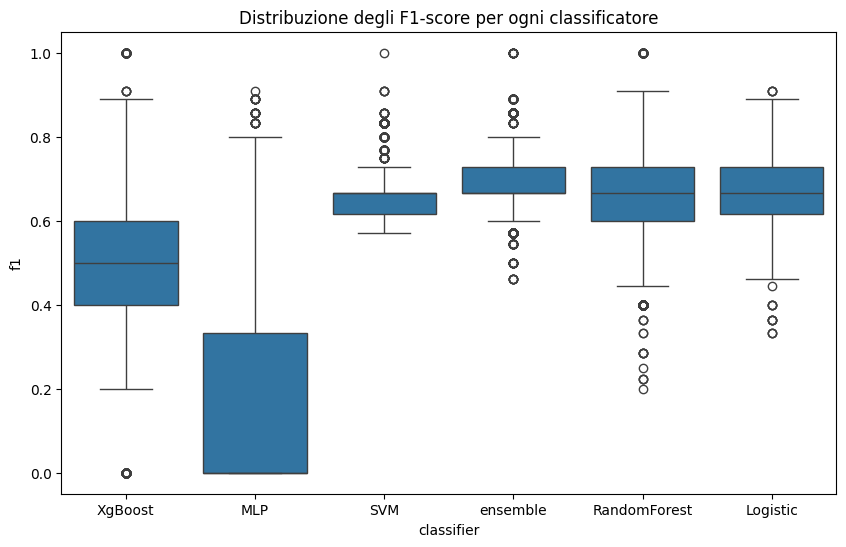

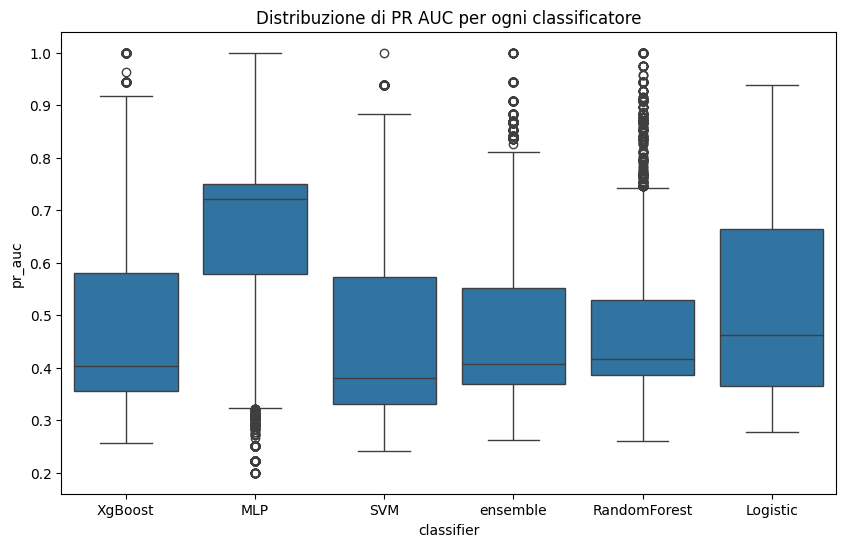

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Converto i risultati in un DataFrame per visualizzare meglio
results_df = pd.DataFrame(results_val)

# Crea un boxplot per l'F1-score
plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='f1', data=results_df)
plt.title('Distribuzione degli F1-score per ogni classificatore')
plt.show()

# Crea un boxplot per PR AUC
plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='pr_auc', data=results_df)
plt.title('Distribuzione di PR AUC per ogni classificatore')
plt.show()


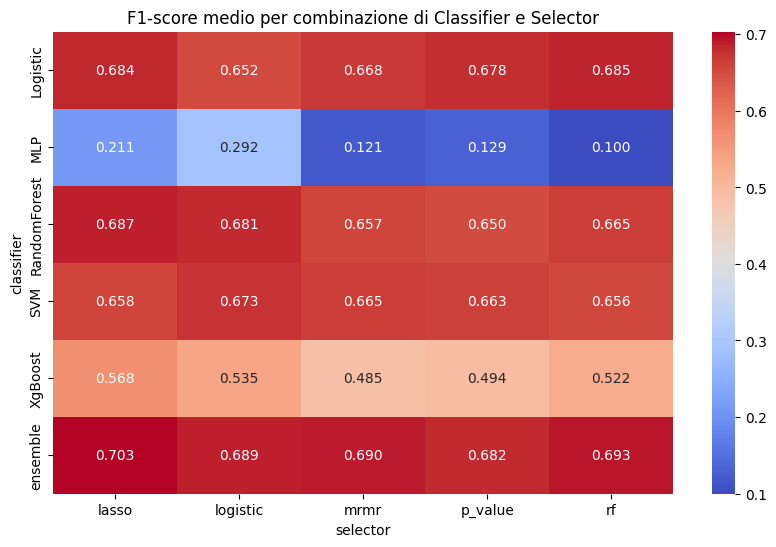

In [4]:

# Crea un pivot per visualizzare i dati nella heatmap
results_df = pd.DataFrame(results_val)
heatmap_data = results_df.pivot_table(index='classifier', columns='selector', values='f1', aggfunc='mean')

# Crea la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('F1-score medio per combinazione di Classifier e Selector')
plt.show()


In [3]:
import pickle

# Carica il dizionario dal file pickle
with open('/Users/alessiamenozzi/Desktop/results_val10fold.pkl', 'rb') as pickle_file:
    results_val = pickle.load(pickle_file)

# Ora 'results_val' contiene i dati che hai salvato
print("Dati caricati correttamente:", type(results_val))


Dati caricati correttamente: <class 'list'>


In [3]:
from collections import Counter

# Dictionary per tenere traccia della frequenza di selezione delle feature
feature_counts = Counter()

# Itera attraverso tutti i risultati e conta le feature selezionate
for res in results_val:
    # Controlla se 'selected_features' è presente ed è una lista non vuota
    selected_features = res.get('selected_features', None)
    if selected_features is not None and len(selected_features) > 0:
        # Aggiorna il contatore con le feature selezionate
        feature_counts.update(selected_features)

# Ordina le feature in base alla frequenza di selezione
sorted_features = feature_counts.most_common()
print(sorted_features)
features=[]
# Stampa le prime 10 feature più selezionate
print("Feature più selezionate:")
for feature, count in sorted_features[:20]:
    print(f"Feature {feature}: selezionata {count} volte")
    features.append(features)


# Ottieni i nomi delle colonne corrispondenti agli indici
selected_feature_names = df_features.columns[features]
print(selected_feature_names)
# Stampa i nomi delle feature selezionate
print("Nomi delle feature selezionate:")
for feature_name in selected_feature_names:
    print(feature_name)


[(104, 19437), (11, 18966), (3, 18649), (7, 18566), (5, 18274), (36, 18069), (15, 17870), (94, 17747), (51, 17673), (4, 17080), (31, 16758), (8, 16615), (22, 16509), (64, 16505), (89, 16427), (13, 16362), (84, 16214), (97, 16171), (19, 16149), (40, 16065), (73, 16065), (34, 16019), (35, 15846), (91, 15795), (21, 15777), (68, 15776), (79, 15706), (88, 15598), (20, 15582), (72, 15577), (27, 15464), (62, 15329), (70, 15329), (38, 15320), (100, 15198), (57, 15036), (26, 14974), (32, 14606), (25, 14539), (6, 14490), (90, 14439), (18, 14428), (55, 14200), (67, 14189), (78, 14157), (86, 14154), (56, 14085), (43, 14070), (33, 13990), (39, 13836), (75, 13795), (1, 13751), (24, 13628), (47, 13619), (37, 13578), (2, 13450), (29, 13414), (60, 13340), (0, 13215), (92, 13146), (101, 13125), (105, 13101), (28, 13064), (44, 12832), (61, 12817), (48, 12752), (9, 12426), (96, 12421), (59, 12316), (63, 12279), (50, 12190), (23, 12065), (99, 11980), (16, 11959), (102, 11900), (53, 11731), (14, 11423), (95

NameError: name 'df_features' is not defined

In [63]:

results_list = []

# Itera attraverso i valori da 2 a 107
for alpha in alpha_values:
    # Esegui la classificazione

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    logistic_model = LogisticRegression(random_state=42)
    svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
    classi = VotingClassifier(
         estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

# Lista per memorizzare i risultati

    best_case = classification_method('lasso', classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, i, mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))
    
    # Aggiungi il risultato alla lista solo se esiste un best_case valido
    if best_case:
        results_list.append(best_case)
# Ordina i risultati per il valore di F1 in ordine decrescente

sorted_results = sorted(results_list, key=lambda x: x['f1'], reverse=True)

# Stampa i tre migliori risultati
print("I tre migliori risultati basati su F1:")
for i, result in enumerate(sorted_results[:3], start=1):
    print(f"\nRisultato #{i}:")
    print(f"Numero di feature: {result['num_features']}")
    print(f"Alpha: {result['alpha']}")
    print(f"F1 score: {result['f1']}")
    print(f"PR AUC: {result['pr_auc']}")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Selected features: {result['selected_features']}")

I tre migliori risultati basati su F1:

Risultato #1:
Numero di feature: 77
Alpha: 0.00020689655172413793
F1 score: 0.8235294117647058
PR AUC: 0.7477773401027078
Accuracy: 0.875
Selected features: [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  31  32  33  34  35  36  38
  40  48  50  51  52  53  54  55  56  57  59  60  61  62  63  64  65  68
  70  72  73  74  75  78  79  82  84  86  88  89  90  91  92  94  97  99
 100 101 102 104 106]

Risultato #2:
Numero di feature: 63
Alpha: 0.0022758620689655173
F1 score: 0.7368421052631579
PR AUC: 0.7097722895976573
Accuracy: 0.7916666666666666
Selected features: [  2   3   4   6   7   8   9  11  13  14  15  16  18  19  20  21  22  23
  24  25  26  27  28  29  31  32  33  34  35  36  40  48  50  53  55  57
  59  60  61  62  63  64  65  68  70  72  73  75  79  84  86  88  89  90
  91  92  94  97  99 101 102 104 106]

Risultato #3:
Numero di feature: 63
Alpha: 0.0024827586206896

In [64]:
n_folds=10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    

    results_list=[]
    # Itera attraverso i valori da 2 a 107
    for alpha in alpha_values:

        x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
        y_train, y_val = Y_train[train_index], Y_train[val_index]

        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        logistic_model = LogisticRegression(random_state=42)
        svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                                # Crea l'ensemble con VotingClassifier
        classi = VotingClassifier(
            estimators=[
                                        ('random_forest', rf_model),
                                        ('logistic', logistic_model),
                                        ('svc', svc_model)
                                    ],
                                    voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )
        best_case = classification_method('lasso', classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, i, mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))
        
        # Aggiungi il risultato alla lista solo se esiste un best_case valido
        if best_case:
            results_list.append(best_case)

    # Ordina i risultati per il valore di F1 in ordine decrescente
    sorted_results = sorted(results_list, key=lambda x: x['f1'], reverse=True)

    # Stampa i tre migliori risultati
    print("I tre migliori risultati basati su F1:")
    for i, result in enumerate(sorted_results[:2], start=1):
        print(f"\nRisultato #{i} per fold {fold_idx}:")
        print(f"Numero di feature: {result['num_features']}")
        print(f"Alpha: {result['alpha']}")
        print(f"F1 score: {result['f1']}")
        print(f"PR AUC: {result['pr_auc']}")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Selected features: {result['selected_features']}")

Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
Starting with fold: 0
I tre migliori risultati basati su F1:

Risultato #1 per fold 0:
Numero di feature: 65
Alpha: 0.0010344827586206897
F1 score: 0.8888888888888888
PR AUC: 0.94375
Accuracy: 0.9
Selected features: [  1   2   3   4   5   6   7   8   9  11  13  14  15  16  18  19  20  21
  22  23  24  25  26  27  28  29  31  32  33  34  35  36  40  48  50  53


In [35]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
logistic_model = LogisticRegression(random_state=42)
svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
classi = VotingClassifier(
         estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )


# Itera attraverso i valori da 2 a 107
for alpha in alpha_values:
    # Esegui la classificazione
    best_case = classification_method('lasso', classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, i, mode="Val", selected_features=[0], thresholds=np.arange(0.3, 0.6, 0.01))
    
    # Aggiungi il risultato alla lista solo se esiste un best_case valido
    if best_case:
        results_list.append(best_case)

# Ordina i risultati per il valore di F1 in ordine decrescente
sorted_results = sorted(results_list, key=lambda x: x['f1'], reverse=True)

# Stampa i tre migliori risultati
print("I tre migliori risultati basati su F1:")
for i, result in enumerate(sorted_results[:5], start=1):
    print(f"\nRisultato #{i}:")
    print(f"Numero di feature: {result['num_features']}")
    print(f"Alpha: {result['alpha']}")
    print(f"F1 score: {result['f1']}")
    print(f"PR AUC: {result['pr_auc']}")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Selected features: {result['selected_features']}")

I tre migliori risultati basati su F1:

Risultato #1:
Numero di feature: 77
Alpha: 0.00020689655172413793
F1 score: 0.8235294117647058
PR AUC: 0.7477773401027078
Accuracy: 0.875
Selected features: [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  31  32  33  34  35  36  38
  40  48  50  51  52  53  54  55  56  57  59  60  61  62  63  64  65  68
  70  72  73  74  75  78  79  82  84  86  88  89  90  91  92  94  97  99
 100 101 102 104 106]

Risultato #2:
Numero di feature: 71
Alpha: 0.0006206896551724137
F1 score: 0.7692307692307693
PR AUC: 0.7683201058201058
Accuracy: 0.75
Selected features: [  1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  18  19  20
  21  22  23  24  25  26  27  28  29  31  32  33  34  35  36  40  48  50
  51  53  54  55  56  57  59  60  61  62  63  64  65  68  70  72  73  74
  75  79  82  84  86  88  89  90  91  92  94  97  99 101 102 104 106]

Risultato #3:
Numero di feature: 71
Alpha: 